In [3]:
from math import comb
import numpy as np
import pandas as pd
!pip install pulp
import pulp
import random
import math
from google.colab import files
from tqdm import tqdm
import time
import matplotlib.pyplot as plt

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 45.1 MB/s eta 0:00:00


# Base Variables

In [5]:
uploaded1 = files.upload()

collaboration_matrix = "Collaboration matrix.xlsx"
collaboration_matrix = pd.read_excel(collaboration_matrix, header=None)

Saving Collaboration matrix.xlsx to Collaboration matrix.xlsx


In [6]:
uploaded2 = files.upload()

artist_info = "Top artists by monthly listeners and skillset.xlsx"
artist_info_df = pd.read_excel(artist_info, header=1)

Saving Top artists by monthly listeners and skillset.xlsx to Top artists by monthly listeners and skillset.xlsx


In [7]:
# number of artists to pick from
artist_choices = 25
# number of unique skills to consider
skill_count = 5
# budget constraint
budget = 100000
# each artists's name/stage title
artist_names = artist_info_df.iloc[1:26,0].to_numpy()
# cost to hire each artist
artist_costs = artist_info_df.iloc[1:26,1].to_numpy()
artist_costs = np.round(artist_costs/10000,0)
# skills matrix
artist_skills = artist_info_df.iloc[1:26, 2:].to_numpy()
# collaboration matrix for artist pairing scores
# note that we only use the upper triangle
collab_matrix = collaboration_matrix.iloc[1:26, 1:26].to_numpy()
# multiplier for cohesion penalty in scoring function
cohesion_pen_strength = 4.5


# enforce dimensions
assert artist_costs.shape[0] == artist_choices
assert artist_names.shape[0] == artist_choices
assert artist_skills.shape[0] == artist_choices
assert artist_skills.shape[1] == skill_count
assert collab_matrix.shape[0] == artist_choices
assert collab_matrix.shape[1] == artist_choices

#**L1 Reg formulation**

In [9]:
def l1_score(selection, print_components=False):
    # Filter for skill ratings of selected artists only
    selected_skills = artist_skills[selection]

    # For L1 norm, we simply sum the absolute value of skill values directly
    l1_skills = np.sum(np.abs(selected_skills), axis=0)

    # Sum values for each skill to get total score
    skill_score = np.sum(l1_skills)

    # Get selected indices from selection array
    selected_indices = np.where(selection)[0]

    # Filter for entries including selected artists
    filtered_collabs = collab_matrix[np.ix_(selected_indices, selected_indices)]

    # Sum entries in upper triangle excluding diagonal for collab score
    # Equivalent to summing the collab scores for each unique pairing in selection
    collab_score = np.sum(np.triu(filtered_collabs, k=1))

    # Apply a regularization penalty based on group size
    # Using linear penalty for L1 norm instead of quadratic
    cohesion_penalty = cohesion_pen_strength * np.count_nonzero(selection)

    if print_components:
        print("skill_score:", skill_score, ", collab_score:", collab_score, ", cohesion_penalty:", -cohesion_penalty)

    # Put components together to get final score for objective function
    return skill_score + collab_score - cohesion_penalty

# checks if a given selection is valid (i.e. within budget)
def is_valid(selection):
  return np.sum(artist_costs * selection) <= budget

# print the list of artists that are in the given selection
def print_names(selection):
  print(artist_names[selection])

def group_cost(selection):
    return np.sum(artist_costs * selection)

# Brute Force Solution

In [10]:
# 2^n combinations to check (power set of artists)
combos_to_check = 2 ** artist_choices

print("Combos to check:", combos_to_check)

Combos to check: 33554432


In [11]:
def best_brute_l1():
    best_score = float('-inf')
    best_selection = None

    # Check score for all combinations and pick the best valid option
    for i in tqdm(range(combos_to_check)):
        curr_selection = np.array([False] * artist_choices)
        # Use binary representation to populate selection according to index
        for j in range(artist_choices):
            if i & (1 << j):
                curr_selection[j] = True

        if not is_valid(curr_selection):
            continue

        # Update results
        curr_score = l1_score(curr_selection)
        if curr_score > best_score:
            best_score = curr_score
            best_selection = curr_selection

    return best_selection, best_score

In [ ]:
brute_start_l1 = time.time()
[best_selection_brute_l1, best_score_brute_l1] = best_brute_l1()
brute_time_l1 = time.time() - brute_start_l1
print("Best Score:", best_score_brute_l1)
print("Group Cost:", group_cost(best_selection_brute_l1))
print_names(best_selection_brute_l1)
print("Time Taken (s):", brute_time_l1)

100%|██████████| 33554432/33554432 [19:01<00:00, 29396.50it/s]

Best Score: 953.0
Group Cost: 99957.0
['Ariana Grande' 'Justin Bieber' 'Drake' 'Ed Sheeran' 'David Guetta'
 'Travis Scott' 'Eminem' 'Sabrina Carpenter' 'Kanye West' 'Dua Lipa'
 'Maroon 5' 'Future' 'Sia' 'Calvin Harris']
Time Taken (s): 1141.479178905487


# Greedy Initialization 1

In [12]:
def best_greedy_a_l1():
    best_score, best_selection = float('-inf'), np.array([False] * artist_choices)
    solutions_checked = 0

    while True:
        # Best next greedy selection
        next_selection, next_score = best_selection.copy(), best_score

        # Find the best next artist to add, if any
        for j in range(artist_choices):
            if best_selection[j]:
                continue

            # Create modified selection to check
            curr_selection = best_selection.copy()
            curr_selection[j] = True
            solutions_checked += 1

            if not is_valid(curr_selection):
                continue

            # Update next selection if the current selection is better
            curr_score = l1_score(curr_selection)
            if curr_score > next_score:
                next_score, next_selection = curr_score, curr_selection.copy()

        if next_score > best_score:
            best_score, best_selection = next_score, next_selection.copy()
        else:
            # Terminate if no artist was added
            break

    return best_selection, best_score, solutions_checked

In [13]:
greedy_a_start_l1 = time.time()
[best_selection_greedy_a_l1, best_score_greedy_a_l1, greedy_a_checked_l1] = best_greedy_a_l1()
greedy_a_time = time.time() - greedy_a_start_l1
print("Best Score:", best_score_greedy_a_l1)
print_names(best_selection_greedy_a_l1)
print("Solutions Checked:", greedy_a_checked_l1)
print("Group Cost:", group_cost(best_selection_greedy_a_l1))
print("Time Taken (s):", greedy_a_start_l1)

Best Score: 784.5
['The Weeknd' 'Billie Eilish' 'SZA' 'Bad Bunny' 'Ariana Grande'
 'Justin Bieber' 'Drake' 'Ed Sheeran' 'Travis Scott' 'Sabrina Carpenter'
 'Post Malone']
Solutions Checked: 234
Group Cost: 95761.0
Time Taken (s): 1743616730.6843302


# Greedy Initialization 2

In [14]:
def best_greedy_b_l1():
    best_score, best_selection = float('-inf'), np.array([False] * artist_choices)
    solutions_checked = 0

    while True:
        # Most efficient next greedy selection found so far
        next_selection, next_score, next_efficiency = best_selection.copy(), best_score, 0

        # Find the most efficient next artist to add, if any
        for j in range(artist_choices):
            if best_selection[j]:
                continue

            # Create modified selection to check
            curr_selection = best_selection.copy()
            curr_selection[j] = True
            solutions_checked += 1

            if not is_valid(curr_selection):
                continue

            curr_score = l1_score(curr_selection)
            # Consider current selection iff it improves on the last iteration
            if curr_score > best_score:
                cost_diff = np.sum(artist_costs * curr_selection) - np.sum(artist_costs * best_selection)
                efficiency = (curr_score - best_score) / cost_diff if cost_diff > 0 else float('inf')
                # Update next selection if the current selection is more efficient
                if efficiency > next_efficiency:
                    next_score, next_selection, next_efficiency = curr_score, curr_selection.copy(), efficiency

        if next_score > best_score:
            best_score, best_selection = next_score, next_selection.copy()
        else:
            # Terminate if no artist was added
            break

    return best_selection, best_score, solutions_checked

In [15]:
greedy_b_start_l1 = time.time()
[best_selection_greedy_b_l1, best_score_greedy_b_l1, greedy_b_checked_l1] = best_greedy_b_l1()
greedy_b_time_l1 = time.time() - greedy_b_start_l1
print("Best Score:", best_score_greedy_b_l1)
print_names(best_selection_greedy_b_l1)
print("Solutions Checked:", greedy_b_checked_l1)
print("Group Cost:", group_cost(best_selection_greedy_b_l1))
print("Time Taken (s):", greedy_b_time_l1)

Best Score: 874.5
['The Weeknd' 'Bad Bunny' 'Drake' 'Ed Sheeran' 'Travis Scott' 'Eminem'
 'Sabrina Carpenter' 'Post Malone' 'Kanye West' 'Dua Lipa' 'Future' 'Sia'
 'Calvin Harris']
Solutions Checked: 259
Group Cost: 98138.0
Time Taken (s): 0.021797895431518555


# Integer Programming Method

In [16]:
def integer_programming():
    prob = pulp.LpProblem("ArtistSelection", pulp.LpMaximize)

    # x is the binary decision variable for artists
    # z is the collaboration decision variable
    x = [pulp.LpVariable(f"x_{i}", cat='Binary') for i in range(artist_choices)]
    z = {}
    for i in range(artist_choices):
        for j in range(i+1, artist_choices):
            z[i, j] = pulp.LpVariable(f"z_{i}_{j}", cat='Binary')

    # Skill score calculation (consistent with L1 method)
    skill_score = sum(sum(abs(artist_skills[i, j]) * x[i] for i in range(artist_choices)) for j in range(skill_count))

    # Collab score calculation (handle both DataFrame and numpy array)
    collab_score = 0

    collab_score = sum(collab_matrix[i, j] * z[i, j]
                       for i in range(artist_choices)
                       for j in range(i + 1, artist_choices)
                       if not np.isnan(collab_matrix[i, j]))

    # Cohesion penalty (consistent with L1 method)
    cohesion_penalty = cohesion_pen_strength * sum(x)

    # Objective function
    prob += skill_score + collab_score - cohesion_penalty

    # Budget constraint
    prob += sum(artist_costs[i] * x[i] for i in range(artist_choices)) <= budget

    # Collaboration constraints
    for i in range(artist_choices):
        for j in range(i+1, artist_choices):
            prob += z[i, j] <= x[i]
            prob += z[i, j] <= x[j]
            prob += z[i, j] >= x[i] + x[j] - 1

    # Solve
    prob.solve()

    # Get solution
    selected_artists = [artist_names[i] for i in range(artist_choices) if pulp.value(x[i]) == 1]
    best_selection_ip = np.array([int(pulp.value(x[i])) for i in range(artist_choices)])
    objective_value = pulp.value(prob.objective)

    print("Objective Value:", objective_value)
    print("Selected Artists:", selected_artists)
    print("Skill Score:", pulp.value(skill_score))
    print("Collab Score:", pulp.value(collab_score))
    print("Group Cost:", group_cost(best_selection_ip))
    print("Cohesion Penalty:", pulp.value(cohesion_penalty))

    return best_selection_ip

In [17]:
ip_start = time.time()
best_selection_ip = integer_programming()
ip_time = time.time() - ip_start
print("Time Taken (s):", ip_time)

Objective Value: 953.0
Selected Artists: ['Ariana Grande', 'Justin Bieber', 'Drake', 'Ed Sheeran', 'David Guetta', 'Travis Scott', 'Eminem', 'Sabrina Carpenter', 'Kanye West', 'Dua Lipa', 'Maroon 5', 'Future', 'Sia', 'Calvin Harris']
Skill Score: 424.0
Collab Score: 592.0
Group Cost: 99957.0
Cohesion Penalty: 63.0
Time Taken (s): 46.83969759941101


# Simulated Annealing Method

In [ ]:
def simulated_annealing_l1(iters=1000, initial_temp=100, cooling_rate=0.999):
    best_score, best_selection = float('-inf'), np.array([False] * artist_choices)
    curr_score, curr_selection = best_score, best_selection.copy()
    temp = initial_temp

    for i in range(iters):
        new_selection = curr_selection.copy()
        flip_idx = random.randint(0, artist_choices - 1)
        new_selection[flip_idx] = not new_selection[flip_idx]

        if not is_valid(new_selection):
            continue

        new_score = l1_score(new_selection)
        delta = new_score - curr_score

        if delta > 0 or random.random() < math.exp(delta / temp):
            curr_selection, curr_score = new_selection.copy(), new_score
            if new_score > best_score:
                best_selection, best_score = new_selection.copy(), new_score

        temp *= cooling_rate
    return best_selection, best_score

In [ ]:
# since simulated annealing produces a non-deterministic (unseeded random) result,
# we run it multiple times to get a more reliable measure of performance
def multi_sa_l1(sample_size=100):
    best_score = float('-inf')
    best_selection = np.array([False] * artist_choices)
    total_score = 0

    for i in range(sample_size):
        selection, score = simulated_annealing_l1(10000, 100, 0.999)
        total_score += score

        if score > best_score:
            best_score, best_selection = score, selection

    return best_selection, best_score, total_score / sample_size

In [ ]:
sa_sample_size_l1 = 100
sa_start_l1 = time.time()
best_selection_sa_l1, best_score_sa_l1, mean_score_sa_l1 = multi_sa_l1(sa_sample_size_l1)
sa_time_l1 = time.time() - sa_start_l1

print("Best Score:", best_score_sa_l1)
print_names(best_selection_sa_l1)
print("Total Time Taken (s):", sa_time_l1)
print("Group Cost:", group_cost(best_selection_sa_l1))
print("Mean Score:", mean_score_sa_l1)
print("Mean Time Taken (s):", sa_time_l1 / sa_sample_size_l1)

Best Score: 943.0
['Bad Bunny' 'Drake' 'Ed Sheeran' 'David Guetta' 'Travis Scott' 'Eminem'
 'Sabrina Carpenter' 'Post Malone' 'Kanye West' 'Dua Lipa' 'Maroon 5'
 'J Balvin' 'Sia' 'Calvin Harris']
Total Time Taken (s): 30.16875171661377
Group Cost: 99445.0
Mean Score: 895.64
Mean Time Taken (s): 0.3016875171661377


# Cohesion Penalty Analysis for L1 (using IP)

Objective Value: 1016.0
Selected Artists: ['Ariana Grande', 'Justin Bieber', 'Drake', 'Ed Sheeran', 'David Guetta', 'Travis Scott', 'Eminem', 'Sabrina Carpenter', 'Kanye West', 'Dua Lipa', 'Maroon 5', 'Future', 'Sia', 'Calvin Harris']
Skill Score: 424.0
Collab Score: 592.0
Group Cost: 99957.0
Cohesion Penalty: 0.0
Objective Value: 1008.6315789473683
Selected Artists: ['Ariana Grande', 'Justin Bieber', 'Drake', 'Ed Sheeran', 'David Guetta', 'Travis Scott', 'Eminem', 'Sabrina Carpenter', 'Kanye West', 'Dua Lipa', 'Maroon 5', 'Future', 'Sia', 'Calvin Harris']
Skill Score: 424.0
Collab Score: 592.0
Group Cost: 99957.0
Cohesion Penalty: 7.368421052631578
Objective Value: 1001.2631578947367
Selected Artists: ['Ariana Grande', 'Justin Bieber', 'Drake', 'Ed Sheeran', 'David Guetta', 'Travis Scott', 'Eminem', 'Sabrina Carpenter', 'Kanye West', 'Dua Lipa', 'Maroon 5', 'Future', 'Sia', 'Calvin Harris']
Skill Score: 424.0
Collab Score: 592.0
Group Cost: 99957.0
Cohesion Penalty: 14.736842105263156

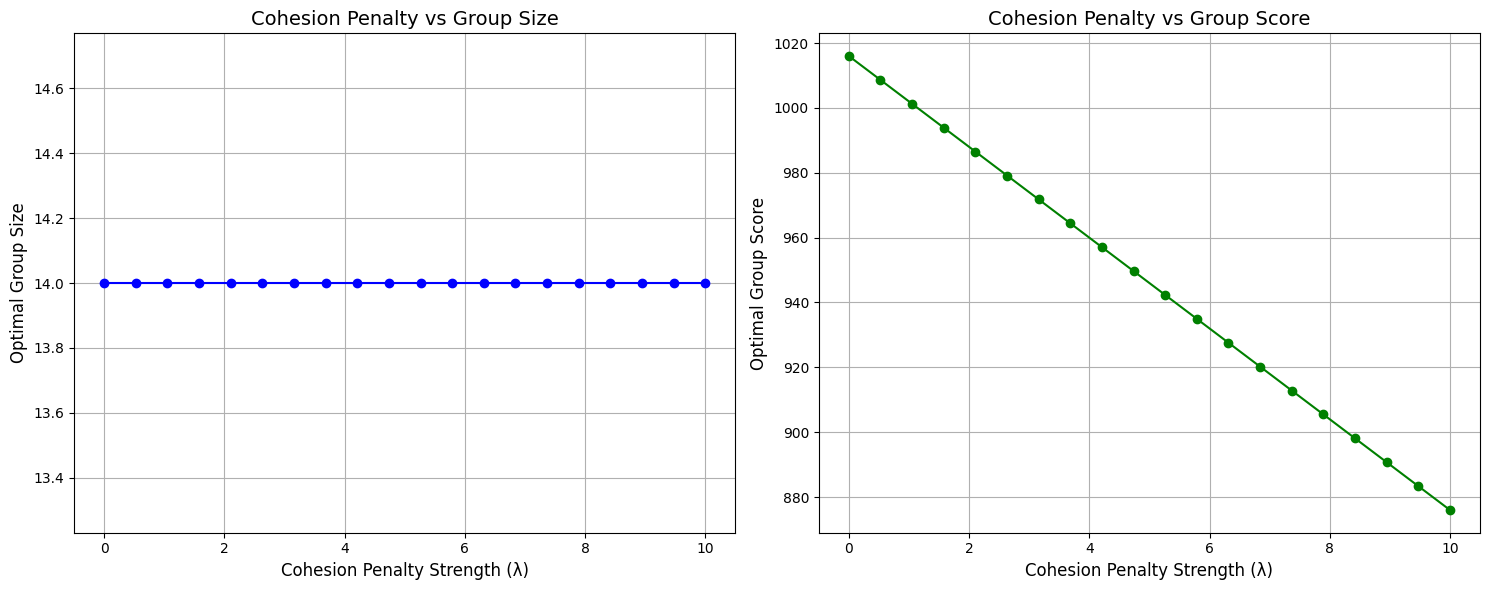

In [31]:
def cohesion_penalty_analysis():
    cohesion_strengths = np.linspace(0, 10, 20)
    group_sizes = []
    penalties = []
    best_scores = []

    original_cohesion_pen_strength = 4.5
    temp_artist_skills = artist_skills.copy()
    temp_collab_matrix = collab_matrix.copy()

    for strength in cohesion_strengths:
        global cohesion_pen_strength
        cohesion_pen_strength = strength
        best_selection_ip = integer_programming()

        skill_value = sum(sum(abs(artist_skills[i, j]) * best_selection_ip[i] for i in range(artist_choices)) for j in range(skill_count))

        collab_value = 0
        for i in range(artist_choices):
            for j in range(i + 1, artist_choices):
                if not np.isnan(collab_matrix[i, j]) and best_selection_ip[i] == 1 and best_selection_ip[j] == 1:
                    collab_value += collab_matrix[i, j]

        group_size = np.count_nonzero(best_selection_ip)
        penalty = strength * group_size

        group_sizes.append(group_size)
        penalties.append(penalty)
        total_score = skill_value + collab_value - penalty
        best_scores.append(total_score)

    cohesion_pen_strength = original_cohesion_pen_strength

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Cohesion Penalty vs Group Size
    ax1.plot(cohesion_strengths, group_sizes, marker='o', color='blue')
    ax1.set_xlabel('Cohesion Penalty Strength (λ)', fontsize=12)
    ax1.set_ylabel('Optimal Group Size', fontsize=12)
    ax1.set_title('Cohesion Penalty vs Group Size', fontsize=14)
    ax1.grid(True)

    # Plot 2: Cohesion Penalty vs Best Score
    ax2.plot(cohesion_strengths, best_scores, marker='o', color='green')
    ax2.set_xlabel('Cohesion Penalty Strength (λ)', fontsize=12)
    ax2.set_ylabel('Optimal Group Score', fontsize=12)
    ax2.set_title('Cohesion Penalty vs Group Score', fontsize=14)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return cohesion_strengths, group_sizes, best_scores

cohesion_strengths, group_sizes, best_scores = cohesion_penalty_analysis()

In [1]:
# function to calculate skill scores for a given selection
def calculate_skill_scores(selection):
    selected_skills = artist_skills[selection]
    skills_rss = np.sqrt(np.sum(selected_skills**2, axis=0))
    return skills_rss

# calculate skill scores for each method
brute_force_skills = calculate_skill_scores(best_selection_brute_l1)
greedy_a_skills = calculate_skill_scores(best_selection_greedy_a_l1)
greedy_b_skills = calculate_skill_scores(best_selection_greedy_b_l1)
ip_skills = calculate_skill_scores(best_selection_ip.astype(bool))
sa_skills = calculate_skill_scores(best_selection_sa_l1)

# dataframe of skills for each method
skill_names = artist_info_df.columns[2:].tolist()  # Assuming skill names are in columns 2 onwards
data = {
    'Skill': skill_names,
    'Brute Force': brute_force_skills,
    'Greedy A': greedy_a_skills,
    'Greedy B': greedy_b_skills,
    'Integer Programming': ip_skills,
    'Simulated Annealing': sa_skills
}
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
x = np.arange(len(skill_names))

ax.bar(x - 2*bar_width, df['Brute Force'], width=bar_width, label='Brute Force', color='#1f77b4')
ax.bar(x - bar_width, df['Greedy A'], width=bar_width, label='Greedy A', color='#ff7f0e')
ax.bar(x, df['Greedy B'], width=bar_width, label='Greedy B', color='#2ca02c')
ax.bar(x + bar_width, df['Integer Programming'], width=bar_width, label='Integer Programming', color='#d62728')
ax.bar(x + 2*bar_width, df['Simulated Annealing'], width=bar_width, label='Simulated Annealing', color='#9467bd')

ax.set_xlabel('Skills', fontsize=12, fontweight='bold')
ax.set_ylabel('Skill Score', fontsize=12, fontweight='bold')
ax.set_title('Skill Breakdown Comparison Across Different Methods (L1 Formulation)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(skill_names, rotation=45, ha='right')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3)
ax.grid(axis='y', linestyle='--', alpha=0.7)

for i, method in enumerate(['Brute Force', 'Greedy A', 'Greedy B', 'Integer Programming', 'Simulated Annealing']):
    for j, value in enumerate(df[method]):
        ax.text(j + (i - 2) * bar_width, value + 0.1,
                f'{value:.1f}', ha='center', va='bottom',
                fontsize=8, rotation=90)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.savefig('skill_breakdown_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

NameError: name 'best_selection_brute_l1' is not defined

#**L2 Reg formulation**

In [ ]:
# objective function to maximize
# selection is a 1d numpy bool array of len=artist_choices
def score(selection, print_components = False):
  # filter for skill ratings of selected artists only
  selected_skills = artist_skills[selection]
  # retrieve the root sum squared for each skill category
  # e.g. if we have 3 selected artists and they have singing skill scores of
  # [4,5,8], then the singing score of the group is sqrt(4^2+5^2+8^2)=10.25
  skills_rss = np.sqrt(np.sum(selected_skills**2, axis=0))
  # sum values for each skill to get total score
  skill_score = np.sum(skills_rss)

  # get selected indices from selection array
  selected_indices = np.where(selection)[0]
  # filter for entries including selected artists
  filtered_collabs = collab_matrix[np.ix_(selected_indices, selected_indices)]
  # sum entries in upper triangle excluding diagonal for collab score
  # equivalent to summing the collab scores for each unique pairing in selection
  collab_score = np.sum(np.triu(filtered_collabs, k=1))

  # apply an L2 regularization penalty that scales quadratically with group size
  # e.g. for 3 artists this is strength * 9 and for 5 artists it is strength * 25
  cohesion_penalty = cohesion_pen_strength * np.count_nonzero(selection) ** 2

  if (print_components):
    print("skill_score:", skill_score, ", collab_score:", collab_score, ", cohesion_penalty:", -cohesion_penalty)

  # put components together to get final score for objective function
  return skill_score + collab_score - cohesion_penalty

# checks if a given selection is valid (i.e. within budget)
def is_valid(selection):
  return np.sum(artist_costs * selection) <= budget

# print the list of artists that are in the given selection
def print_names(selection):
  print(artist_names[selection])

def group_cost(selection):
    return np.sum(artist_costs * selection)

# Brute Force Solution

In [ ]:
def best_brute():
  best_score = 0
  best_selection = None

  # check score for all combinations and pick the best valid option
  for i in tqdm(range(combos_to_check)):
    curr_selection = np.array([False]*artist_choices)
    # use binary representation to populate selection according to index
    for j in range(artist_choices):
      if (i & (1 << j)):
        curr_selection[j] = True

    if not is_valid(curr_selection):
      continue

    # update results
    curr_score = score(curr_selection)
    if curr_score > best_score:
      best_score = curr_score
      best_selection = curr_selection

  return best_selection, best_score


In [ ]:
brute_start = time.time()
[best_selection_brute, best_score_brute] = best_brute()
brute_time = time.time() - brute_start
print("Best Score:", best_score_brute)
print("Group Cost:", group_cost(best_selection_brute))
print_names(best_selection_brute)
print("Time Taken (s):", brute_time)

100%|██████████| 33554432/33554432 [19:58<00:00, 27994.80it/s]

Best Score: 65.32487945046881
Group Cost: 73839.0
['The Weeknd' 'Billie Eilish' 'SZA' 'Taylor Swift' 'Ariana Grande'
 'Justin Bieber' 'Drake' 'Ed Sheeran']
Time Taken (s): 1198.5978169441223


# Greedy Initialization 1

At each step, pick the artist that adds the most sales out of artists that can be afforded without considering cost-efficiency

In [ ]:
def best_greedy_a():
  best_score, best_selection = 0, np.array([False]*artist_choices)
  solutions_checked = 0

  while True:
    # best next greedy selection
    next_selection, next_score = best_selection, best_score

    # find the best next artist to add, if any
    for j in range(artist_choices):
      if best_selection[j]:
        continue

      # create modified selection to check
      curr_selection = best_selection.copy()
      curr_selection[j] = True
      solutions_checked += 1

      if not is_valid(curr_selection):
        continue

      # update next selection if the current selection is better
      curr_score = score(curr_selection)
      if curr_score > next_score:
        next_score, next_selection = curr_score, curr_selection

    if next_score > best_score:
      best_score, best_selection = next_score, next_selection
    else:
      # terminate if no artist was added
      break

  return best_selection, best_score, solutions_checked

In [ ]:
greedy_a_start = time.time()
[best_selection_greedy_a, best_score_greedy_a, greedy_a_checked] = best_greedy_a()
greedy_a_time = time.time() - greedy_a_start
print("Best Score:", best_score_greedy_a)
print_names(best_selection_greedy_a)
print("Solutions Checked:", greedy_a_checked)
print("Group Cost:", group_cost(best_selection_greedy_a))
print("Time Taken (s):", greedy_a_time)

Best Score: 60.52612860813022
['The Weeknd' 'SZA' 'Bad Bunny' 'Drake' 'Post Malone']
Solutions Checked: 135
Group Cost: 46318.0
Time Taken (s): 0.012052297592163086


# Greedy Initialization 2

At each step, pick the artist that generates most sales per dollar spent, subject to budget constraint

In [ ]:
def best_greedy_b():
  best_score, best_selection = 0, np.array([False]*artist_choices)
  solutions_checked = 0

  while True:
    # most efficient next greedy selection found so far
    next_selection, next_score, next_efficiency = best_selection, best_score, 0

    # find the most efficient next artist to add, if any
    for j in range(artist_choices):
      if best_selection[j]:
        continue

      # create modified selection to check
      curr_selection = best_selection.copy()
      curr_selection[j] = True
      solutions_checked += 1

      if not is_valid(curr_selection):
        continue

      curr_score = score(curr_selection)
      # consider current selection iff it improves on the last iteration
      if curr_score > best_score:
        cost_diff = np.sum(artist_costs * curr_selection) - np.sum(artist_costs * best_selection)
        efficiency = (curr_score - best_score) / cost_diff
        # update next selection if the current selection is more efficient
        if efficiency > next_efficiency:
          next_score, next_selection, next_efficiency = curr_score, curr_selection, efficiency

    if next_score > best_score:
      best_score, best_selection = next_score, next_selection
    else:
      # terminate if no artist was added
      break

  return best_selection, best_score, solutions_checked

In [ ]:
greedy_b_start = time.time()
[best_selection_greedy_b, best_score_greedy_b, greedy_b_checked] = best_greedy_b()
greedy_b_time = time.time() - greedy_b_start
print("Best Score:", best_score_greedy_b)
print_names(best_selection_greedy_b)
print("Solutions Checked:", greedy_b_checked)
print("Group Cost:", group_cost(best_selection_greedy_b))
print("Time Taken (s):", greedy_b_time)

Best Score: 53.68637826339088
['Bad Bunny' 'Travis Scott' 'Post Malone' 'Kanye West']
Solutions Checked: 115
Group Cost: 30071.0
Time Taken (s): 0.00818777084350586


# Simulated Annealing Method

In [ ]:
def simulated_annealing(iters=1000, initial_temp=100, cooling_rate=0.999):
  # initialize algorithm with an empty selection
  best_score, best_selection = 0, np.array([False]*artist_choices)
  curr_score, curr_selection = best_score, best_selection.copy()
  temp = initial_temp

  for i in range(iters):
    # get a new selection by randomly adding/removing one artist from the current selection
    new_selection = curr_selection.copy()
    flip_idx = random.randint(0, artist_choices - 1)
    new_selection[flip_idx] = not new_selection[flip_idx]

    if not is_valid(new_selection):
      continue

    new_score = score(new_selection)
    delta = new_score - curr_score

    # may accept worse solutions with a chance determined by current temp
    if delta > 0 or random.random() < math.exp(delta / temp):
      curr_selection, curr_score = new_selection.copy(), new_score

      # IMPORTANT: best selection is set and stored separately from current selection
      if new_score > best_score:
        best_selection, best_score = new_selection.copy(), new_score

    temp *= cooling_rate
  return best_selection, best_score

In [ ]:
# since simulated annealing produces a non-deterministic (unseeded random) result,
# we run it multiple times to get a more reliable measure of performance
def multi_sa(sample_size=100):
  best_score = 0
  best_selection = np.array([False]*artist_choices)
  total_score = 0

  for i in range(sample_size):
    # hand-picked some params that seem to work well
    selection, score = simulated_annealing(10000, 100, 0.999)

    total_score += score

    if score > best_score:
      best_score, best_selection = score, selection

  return best_selection, best_score, total_score / sample_size

In [ ]:
sa_sample_size = 100
sa_start = time.time()
best_selection_sa, best_score_sa, mean_score_sa = multi_sa(sa_sample_size)
sa_time = time.time() - sa_start

print("Best Score:", best_score_sa)
print_names(best_selection_sa)
print("Total Time Taken (s):", sa_time)
print("Group Cost:", group_cost(best_selection_sa))
print("Mean Score:", mean_score_sa)
print("Mean Time Taken (s):", sa_time / sa_sample_size)

Best Score: 65.32487945046881
['The Weeknd' 'Billie Eilish' 'SZA' 'Taylor Swift' 'Ariana Grande'
 'Justin Bieber' 'Drake' 'Ed Sheeran']
Total Time Taken (s): 53.206340312957764
Group Cost: 73839.0
Mean Score: 65.29193995132384
Mean Time Taken (s): 0.5320634031295777


# Skill breakdown for group selected for each method

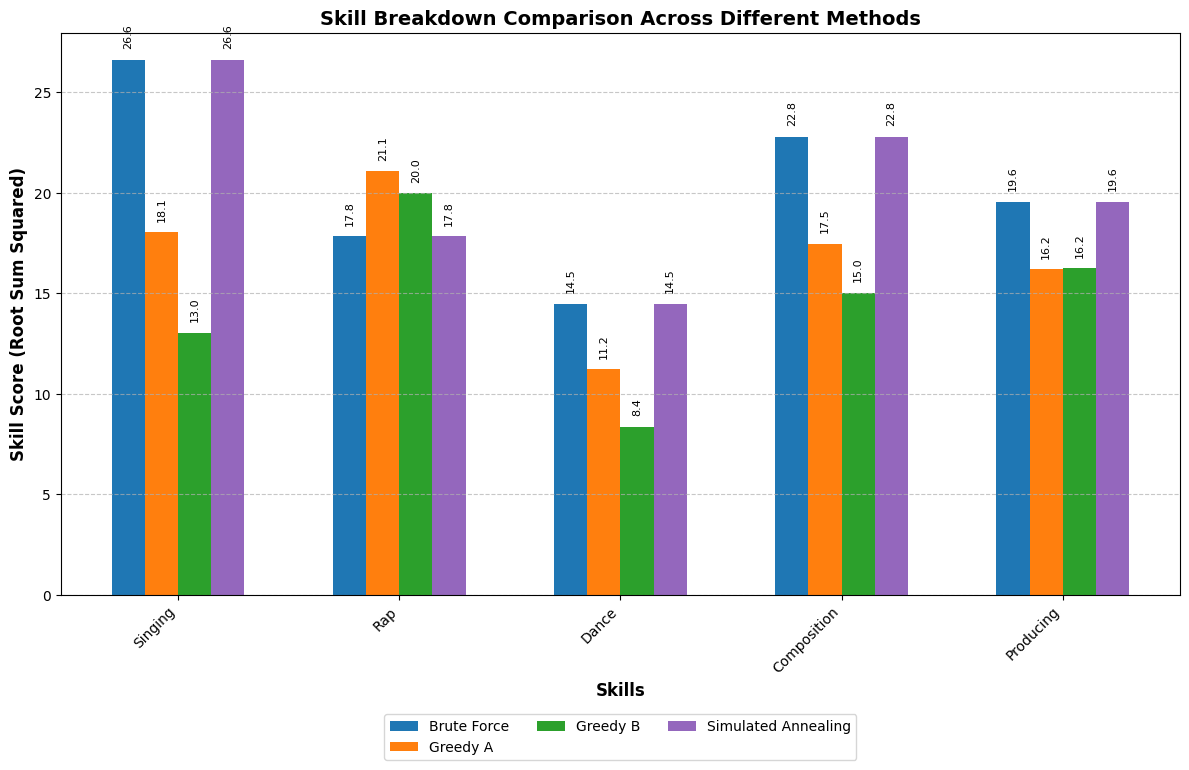

In [ ]:
# function to calculate skill scores for a given selection
def calculate_skill_scores(selection):
    selected_skills = artist_skills[selection]
    skills_rss = np.sqrt(np.sum(selected_skills**2, axis=0))
    return skills_rss

# calculate skill scores for each method
brute_force_skills = calculate_skill_scores(best_selection_brute)
greedy_a_skills = calculate_skill_scores(best_selection_greedy_a)
greedy_b_skills = calculate_skill_scores(best_selection_greedy_b)
sa_skills = calculate_skill_scores(best_selection_sa)

# dataframe of skills for each method
skill_names = artist_info_df.columns[2:].tolist()
data = {
    'Skill': skill_names,
    'Brute Force': brute_force_skills,
    'Greedy A': greedy_a_skills,
    'Greedy B': greedy_b_skills,
    'Simulated Annealing': sa_skills
}
df = pd.DataFrame(data)
fig, ax = plt.subplots(figsize=(12, 8))
bar_width = 0.15
x = np.arange(len(skill_names))

ax.bar(x - 1.5*bar_width, df['Brute Force'], width=bar_width, label='Brute Force', color='#1f77b4')
ax.bar(x - 0.5*bar_width, df['Greedy A'], width=bar_width, label='Greedy A', color='#ff7f0e')
ax.bar(x + 0.5*bar_width, df['Greedy B'], width=bar_width, label='Greedy B', color='#2ca02c')
ax.bar(x + 1.5*bar_width, df['Simulated Annealing'], width=bar_width, label='Simulated Annealing', color='#9467bd')

ax.set_xlabel('Skills', fontsize=12, fontweight='bold')
ax.set_ylabel('Skill Score (Root Sum Squared)', fontsize=12, fontweight='bold')
ax.set_title('Skill Breakdown Comparison Across Different Methods', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(skill_names, rotation=45, ha='right')

ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.20), ncol=3)
ax.grid(axis='y', linestyle='--', alpha=0.7)

bar_positions = [-1.5, -0.5, 0.5, 1.5]

for i, method in enumerate(['Brute Force', 'Greedy A', 'Greedy B', 'Simulated Annealing']):
    for j, value in enumerate(df[method]):
        ax.text(j + bar_positions[i] * bar_width, value + (max(df.iloc[:, 1:].values.flatten()) * 0.02),
                f'{value:.1f}', ha='center', va='bottom',
                fontsize=8, rotation=90)

plt.tight_layout()
plt.subplots_adjust(bottom=0.25)
plt.savefig('skill_breakdown_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Group Size vs Cohension Penalty Strength visualization

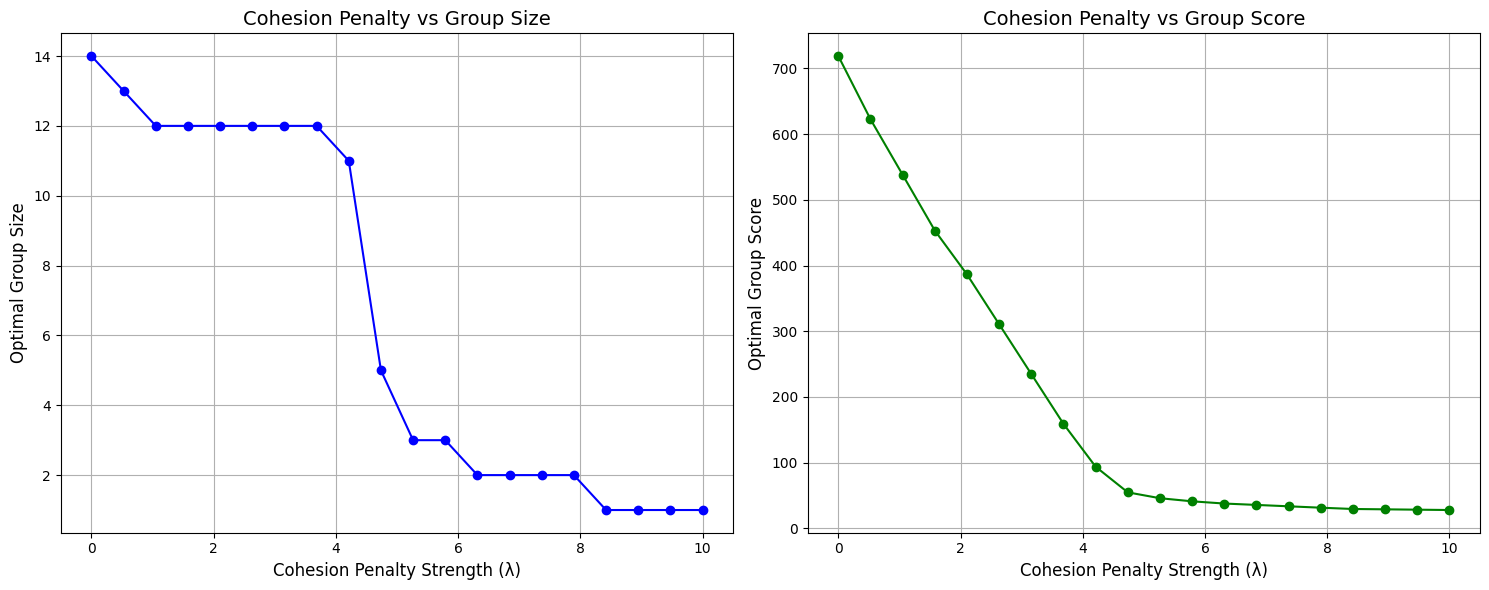

In [ ]:
def cohesion_penalty_analysis():
    cohesion_strengths = np.linspace(0, 10, 20)
    group_sizes = []
    penalties = []
    best_scores = []

    original_cohesion_pen_strength = 4.5
    temp_artist_skills = artist_skills.copy()
    temp_collab_matrix = collab_matrix.copy()

    for strength in cohesion_strengths:
        global cohesion_pen_strength
        cohesion_pen_strength = strength

        best_selection_sa, best_score_sa, mean_score_sa = multi_sa(sa_sample_size)
        group_size = np.count_nonzero(best_selection_sa)

        group_sizes.append(group_size)
        penalties.append(strength * group_size**2)
        best_scores.append(best_score_sa)

    cohesion_pen_strength = original_cohesion_pen_strength


    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Plot 1: Cohesion Penalty vs Group Size
    ax1.plot(cohesion_strengths, group_sizes, marker='o', color='blue')
    ax1.set_xlabel('Cohesion Penalty Strength (λ)', fontsize=12)
    ax1.set_ylabel('Optimal Group Size', fontsize=12)
    ax1.set_title('Cohesion Penalty vs Group Size', fontsize=14)
    ax1.grid(True)

    # Plot 2: Cohesion Penalty vs Best Score
    ax2.plot(cohesion_strengths, best_scores, marker='o', color='green')
    ax2.set_xlabel('Cohesion Penalty Strength (λ)', fontsize=12)
    ax2.set_ylabel('Optimal Group Score', fontsize=12)
    ax2.set_title('Cohesion Penalty vs Group Score', fontsize=14)
    ax2.grid(True)

    plt.tight_layout()
    plt.show()

    return cohesion_strengths, group_sizes, best_scores

cohesion_strengths, group_sizes, best_scores = cohesion_penalty_analysis()